In [ ]:
## initial data capture

In [ ]:
# from bs4 import BeautifulSoup
# import requests
# import pandas as pd

In [ ]:
# dates = []
# topics = []
# results = []
# years = []

# for year in range(2000, 2020):
#     url_base = "https://research.un.org/en/docs/sc/quick/meetings/"
#     #year = 2018
#     year_str = str(year)
#     year_url = url_base + year_str

#     page = requests.get(year_url)
#     #soup = BeautifulSoup(page.content, "html.parser")
#     soup = BeautifulSoup(page.content, "lxml")
    

#     table = soup.find_all("table", class_ = "tablefont")
#     #table = div.find_all("table", class="tablefont")
#     if (len(table) == 1):
#         tds = table[0].find_all("td")
#         for i, td in enumerate(tds):
#             if i % 5 == 0:
#                 years.append(year)
#             elif i % 5 == 1:
#                 dates.append(td.text)
#             elif i % 5 == 3:
#                 topics.append(td.text)
#             elif i % 5 == 4:
#                 results.append(td.text)
#     else:
#         print("year", year, "didn't have a table")

# print(len(dates), len(topics), len(results))
        
    
    

In [ ]:
# df = pd.DataFrame({"year": years, "date": dates, "topics": topics, "result": results})
# df.to_excel("unsc_2000_2019.xlsx", index = False)

In [ ]:
## clean data

In [1]:
import regex as re
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

from datetime import datetime
import dateutil.parser

In [2]:
# data cleaning
df = pd.read_excel("sample_2000_2019.xlsx")
df["result"] = df["result"].str.replace("\n", "")
df["result"] = df["result"].str.replace("\t", "")

#strip all str cols of leading and trailing whitespace just in case
for col in ["date", "topics", "result"]: 
    df[col] = df[col].str.strip()
    
#df.head(5)

In [3]:
#datetime.strptime("2000 22 December", "%Y %d %B").strftime("%Y-%m-%d")

In [4]:
def format_date(row):
    str_year = str(row["year"])
    str_day_month = row["date"]
    try: 
        to_return = datetime.strptime(str_year + " " + str_day_month, "%Y %d %B").strftime("%Y-%m-%d")
    except:
        #print("other_format", str_day_month)
        to_return = dateutil.parser.parse(str_year + " " + str_day_month)
        
    return to_return

In [5]:
#get a Date column that is a datetime
df["Date"] = df.apply(lambda r: format_date(r), axis = 1)
df["Date_dt"] = pd.to_datetime(df["Date"])
df["month"] = df["Date_dt"].dt.month
df["month/year"] = df["month"].astype(str) + "/" + df["year"].astype(str)
ordinal = CategoricalDtype(categories = df.sort_values("Date_dt")["month/year"].unique().tolist(), ordered = True)
df["Month/Year"] = df["month/year"].astype(ordinal)

In [6]:
def extract_vote_result(raw_result):
    """pass in a string from the result column for one row"""
    if re.search("[0-9]-[0-9]-[0-9]", raw_result): 
        str_str_str = re.search("[0-9]+-[0-9]+-[0-9]+", raw_result).group()
        str_list = str_str_str.split("-")
        num_fav, num_abs, num_aga = int(str_list[0]), int(str_list[1]), int(str_list[2])
        return (num_fav, num_abs, num_aga)
    else:
        None

In [7]:
def categorize_result(raw_result):
    if extract_vote_result(raw_result) is not None:
        action_type = "Resolution: Voted"
    elif "RES" in raw_result:
        action_type = "Resolution: No Vote"
    elif "Election" in raw_result:
        action_type = "Election"
    elif raw_result == "--":
        action_type = "Discussion"
    elif "PRST" in raw_result:
        action_type = "Press Release"
    else:
        action_type = "Note/Letter/Other"
    return action_type

In [8]:
df["Action Type"] = df.apply(lambda r: categorize_result(r["result"]), axis = 1)
#df.head()

In [9]:
#df["Action Type"].value_counts()

In [10]:
#res_vote = df[df["Action Type"] == "Resolution: Voted"]
#res_vote["Voting Result"] = res_vote.apply(lambda r: extract_vote_result(r["result"]), axis = 1)
#res_vote.head()

In [11]:
df["Voting Result"] = df.apply(lambda r: extract_vote_result(r["result"]), axis = 1)

In [12]:
def confirm_vote_result(row):
    if row["Action Type"] == "Resolution: Voted": 
        bool_not = "not adopted" in row["result"]
        bool_veto = "veto" in row["result"]

        num_fav = row["Voting Result"][0]
        if (num_fav < 9) and bool_not:
            return "Lack Majority"
        elif (num_fav >= 9) and bool_veto:
            return "Vetoed"
        elif (num_fav >=9) and bool_not:
            return "?"
        elif num_fav >=9 and (bool_not == False and bool_veto == False):
            return "Adopted"
        else:
            return "?"
    
df["Confirm Vote Result"] = df.apply(lambda r: confirm_vote_result(r), axis = 1)
#|df["Confirm Vote Result"].value_counts()

In [13]:
def find_date_range(df, as_str = False):
    """takes in a subsetted dataframe on one topic"""
    if as_str == True: 
        return (str(df["Date_dt"].dt.date.min()), str(df["Date_dt"].dt.date.max()))
    else: 
        return (df["Date_dt"].dt.date.min(), df["Date_dt"].dt.date.max())

In [14]:
topic_to_daterange = {}
list_of_topics = df["topics"].unique().tolist()
for topic in list_of_topics:
    subset_topic = df[df["topics"] == topic]
    topic_to_daterange[topic] = find_date_range(subset_topic)
    
df["Topic Date Range"] = df["topics"].map(topic_to_daterange)
df["Start"] = df.apply(lambda r: r["Topic Date Range"][0], axis = 1)
df["Finish"] = df.apply(lambda r: r["Topic Date Range"][1], axis = 1)

In [15]:
#df.drop(columns = ["date", "Date", "month/year"], inplace = True)
#df

In [16]:
#df.to_excel("Clean_Meeting_2000_2019.xlsx", index = False)

In [17]:
#interactive widget/line graphs

In [18]:
#widget_width = "350px"
padding = "0px 0px 0px 4px"
action_types = ["All Meetings"] + df["Action Type"].unique().tolist()
#action_types

In [19]:
# def generate_line_graph(my_df, my_tuple, filter_param = "Action Type"):
#     """takes tuple from selectmultiple dropdown's interact value for an ACTION TYPE or TOPIC.
#     filter_param: 'Action Type' or 'topics' "
#     """    
    
#     if "All Meetings" not in my_tuple:
#         my_df = my_df[my_df[filter_param].isin(list(my_tuple))]
        
#     to_graph = my_df.groupby(["Month/Year", "Action Type"]).agg("count")

#     to_graph = to_graph.reset_index()
#     to_graph = to_graph.rename(columns = {"result": "Meetings in Month"})
        
#     fig = px.bar(to_graph, x = "Month/Year", y = "Meetings in Month",
#                   color = "Action Type", title = "Number of Meetings Producing [Action Type]")
#     #fig.update_layout(yaxis = {"range": [min(to_graph["Meetings in Month"].values), max(to_graph["Meetings in Month"].values) + 2]})

#     fig.show()

In [20]:
# actiont_dropdown = widgets.SelectMultiple(
#     options = action_types,
#     value = ["All Meetings"],
#     description = "UNSC Action Over Time:",
#     layout = widgets.Layout(width = "350px", padding = padding),
#     style = {"description_width": "initial"}
# )

# actiont_output = widgets.Output()

# actiont_viz = widgets.Button(
#     description = "Visualize",
#     disabled = False,
#     icon = "chart-area",
#     button_style = "success",
#     layout = widgets.Layout(width = "90px", height = "50px", padding = padding),
#     style = {"description_width": "initial"}
# )

# def generate_lines(look):
#     with actiont_output:
#         actiont_output.clear_output()
#         generate_line_graph(df, actiont_dropdown.get_interact_value(), "Action Type")
        
        
#         #pt 2
        
#         action_type_selected = actiont_dropdown.get_interact_value()

#         if "All Meetings" not in action_type_selected: 
#             df_for_next = df[df["Action Type"].isin(list(action_type_selected))]
#         else:
#             df_for_next = df.copy()
        
#         topic_dropdown = widgets.Select(
#             options = df_for_next["topics"].value_counts().index.tolist()[:10],
#             value = None,
#             description = "Want to Filter Further by Topic?",
#             layout = widgets.Layout(width = "650px", padding = padding),
#             style = {"description_width": "initial"}
#         )

#         topic_output = widgets.Output()

#         topic_viz = widgets.Button(
#             description = "Visualize:",
#             disabled = False,
#             icon = "chart-area",
#             button_style = "success",
#             layout = widgets.Layout(width = "90px", height = "50px", padding = padding),
#             style = {"description_width": "initial"}
#         )

#         def generate_lines2(look):
#             with topic_output:
#                 topic_output.clear_output()
#                 generate_line_graph(df_for_next, tuple([topic_dropdown.get_interact_value()]), "topics")

#         topic_viz.on_click(generate_lines2)

#         topics_w = widgets.VBox([widgets.HBox([topic_dropdown, topic_viz]), topic_output])
#         display(topics_w)

# actiont_viz.on_click(generate_lines)

# actiont_w = widgets.VBox([widgets.HBox([actiont_dropdown, actiont_viz]), actiont_output])
# actiont_w

In [25]:
def categorize_topics(df): 
    topics_easy_hard = {}
    for topic in list_of_topics:
        that_topic = df[df["topics"] == topic]
        #return that_topic
        things_done = that_topic["Action Type"].value_counts().index.tolist()
        if ("Resolution: Voted" not in things_done) and ("Resolution: No Vote" not in things_done):
            topics_easy_hard[topic] = "Discussion Only"

        elif "Resolution: Voted" in things_done:
            result_vote = df["Confirm Vote Result"].value_counts().index.tolist()
            if (("Vetoed" in result_vote) or ("Lack Majority" in result_vote)) and ("Adopted" in result_vote):
                topics_easy_hard[topic] = "Disagreement and Agreement"
            elif "Adopted" in result_vote:
                #all agreement: resolution was voted on but vetoed and lack majority never happened
                topics_easy_hard[topic] = "Agreement Only"
            else:
                topics_easy_hard[topic] = "Disagreement Only"
        else:
            topics_easy_hard[topic] = "Elections (Other)"
    return topics_easy_hard

In [59]:
key = categorize_topics(df)
df["Topic Category"] = df["topics"].map(key)
#df["Topic Category"].value_counts()

In [58]:
by_topic = pd.DataFrame({"Topic": key.keys(), "What Happened": key.values()})
to_table = pd.DataFrame(by_topic["What Happened"].value_counts()).reset_index()
to_table.rename(columns = {"index": "What Happened for the Topic", "What Happened": "Number of Topics"}, inplace = True)
#to_table

## Is passing a resolution as easy as pie?

Between 2000 and 2019,

There are no topics where there is only disagreement:
>- No topics where resolution(s) were brought to the table but none were ever passed on the subject matter

Also: There are no topics where there is only agreement: 
>- No topics where the UNSC has always adopted every resolution on the subject matter

The topics that were voted on all have disagreements and agreements over different resolutions concerning the subject matter.

__TLDR__: There is __agreement and disagreement__ over resolution topics

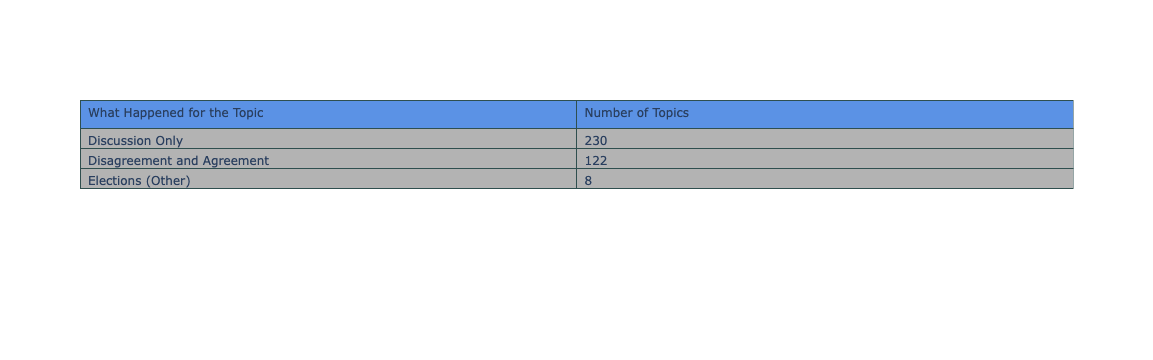

In [57]:
import plotly.graph_objects as go
table = go.Figure(data = [go.Table(
    header = dict(values=list(to_table.columns),
                  line_color= "darkslategray",
                fill_color = "#5b92e5",
                align ='left'),
    cells = dict(values =[to_table["What Happened for the Topic"], to_table["Number of Topics"]],
            line_color= "darkslategray",
               fill_color = "#b3b3b3",
               align ='left'))
])

table.update_layout(width=700, height=300)

table

In [92]:
to_pie = pd.DataFrame(df["Action Type"].value_counts()).reset_index()
to_pie.rename(columns = {"index": "Action Taken at Meeting", "Action Type": "# of Meetings"}, inplace = True)
#to_pie

In [93]:
to_pie2 = pd.DataFrame(df["Confirm Vote Result"].value_counts()).reset_index()
to_pie2.rename(columns = {"index":"Voting Result", "Confirm Vote Result":"# of Occurences"}, inplace = True)
#to_pie2["Voting Result"]
#to_pie2

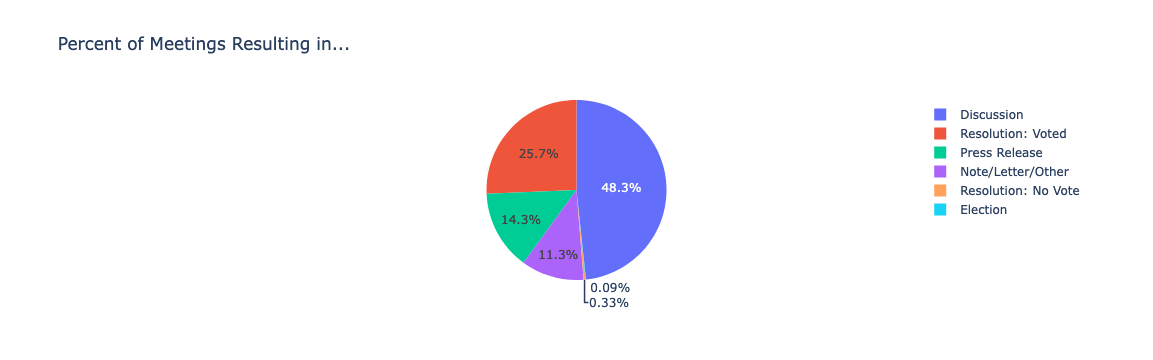

In [94]:
pie_fig = px.pie(to_pie, values = "# of Meetings", names = "Action Taken at Meeting", title = "Percent of Meetings Resulting in...")
pie_fig

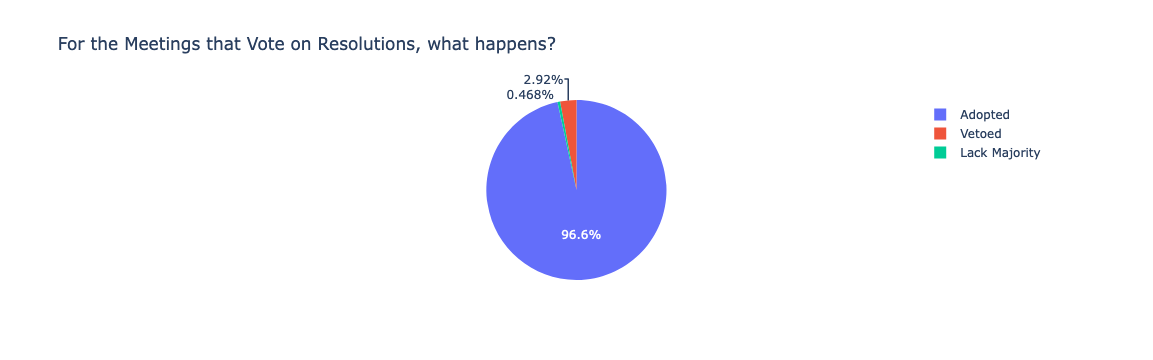

In [95]:
pie_fig2 = px.pie(to_pie2, values = "# of Occurences", names = "Voting Result", title = "For the Meetings that Vote on Resolutions, what happens?")
pie_fig2

In [142]:
# some_topics

In [143]:
# df["topics"]

In [144]:
# def make_timeline(topics_interest): 
#     #show overall date range
#     some_topics = df[df["topics"].isin(topics_interest)]
#     some_topics = some_topics[["topics", "Start", "Finish", "Action Type", "Date"]]
#     fig_gantt = px.timeline(some_topics, x_start = "Start", x_end = "Finish", y = "topics")
#     fig_gantt.update_yaxes(autorange = "reversed")
#     fig_gantt.show()
#     #return some_topics
#     some_topics_action = some_topics[some_topics["Action Type"] == "Resolution: Voted"]
#     fig_point = px.scatter(some_topics_action, x = "Date", y = "topics")
#     fig_point.show()
# make_timeline(["Sierra Leone", "Guinea", "Afghanistan", "Somalia", "The situation in Libya", "The situation in Bosnia and Herzegovina"])

In [145]:
# timefig = px.timeline()

In [146]:
# df["Topic Date Range"][0][0]

In [147]:
# px.scatter(x = good["Date"], symbol = good["Confirm Vote Result"])

In [148]:
# df["Action Type"].value_counts()

In [149]:
# som = df[df["topics"] == "Somalia"]
# actions = pd.DataFrame(som["Action Type"].value_counts()).reset_index()
# assert "Resolution: Voted" in actions["index"].values.tolist()
# good =  som[som["Confirm Vote Result"].notnull()]
# good[]

In [150]:
# for topic in list_of_topics:
#     that_topic = df[df["topics"] = topic]
#     that_topic["Action Type"].value_counts()

In [151]:
# voted = df[df["Action Type"] == "Resolution: Voted"]

In [152]:
# df["Confirm Vote Result"].value_counts()

In [153]:
# df[(df["Confirm Vote Result"] == "Vetoed")| (df["Confirm Vote Result"] == "Lack Majority")]